In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack
import joblib

# Prepare Data

## Load Preprocessed Data

In [2]:
data = pd.read_csv('data/fulltext_preprocessed_data.csv')
data.head()

,full_text,full_tokens,full_text_lemmatized,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,"['house', 'aide', 'even', 'see', 'letter', 'ja...",house aide even see letter jason house aide ev...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...","['hillary', 'clinton', 'big', 'woman', 'campus...",hillary clinton big woman campus ever get feel...,0
2,Why the Truth Might Get You Fired Why the Trut...,"['truth', 'might', 'get', 'fired', 'truth', 'm...",truth might get fired truth might get fired oc...,1
3,15 Civilians Killed In Single US Airstrike Hav...,"['single', 'single', 'rate', 'american', 'high...",single single rate american higher engaged act...,1
4,Iranian woman jailed for fictional unpublished...,"['iranian', 'woman', 'fictional', 'unpublished...",iranian woman fictional unpublished story woma...,1


In [3]:
data.shape

(20546, 4)

In [4]:
style_df = pd.read_csv('data/style_features.csv').drop(columns='label')
style_df.head()

,average_word_length,average_sentence_length,vocabulary_richness,url_ratio,all_caps_ratio,exclamations_ratio,questions_ratio,digits_ratio,flesch_reading_ease_score,noun_ratio,verb_ratio,adjective_ratio,adverb_ratio,pronoun_ratio,proper_noun_ratio,punctuation_ratio
0,4.737278,25.131579,0.463905,0.000000,0.011834,0.0,0.000000,0.004387,48.159824,0.136095,0.126627,0.057988,0.057988,0.102959,0.165680,0.020738
1,4.747504,25.030303,0.543509,0.000000,0.009986,0.0,0.000954,0.007393,54.114539,0.194009,0.119829,0.064194,0.052782,0.111270,0.102710,0.027427
2,4.934295,25.224138,0.469551,0.006410,0.006410,0.0,0.000519,0.002986,45.803364,0.196314,0.111378,0.085737,0.048878,0.081731,0.103365,0.028171
3,4.732852,23.222222,0.453069,0.001805,0.034296,0.0,0.000000,0.009747,52.086600,0.209386,0.120939,0.075812,0.027076,0.050542,0.124549,0.018276
4,5.104294,37.600000,0.595092,0.000000,0.000000,0.0,0.000000,0.005848,27.212727,0.257669,0.153374,0.049080,0.012270,0.067485,0.092025,0.021442


In [5]:
style_df.shape

(20546, 16)

In [6]:
style_df.loc[style_df['flesch_reading_ease_score']<0]

,average_word_length,average_sentence_length,vocabulary_richness,url_ratio,all_caps_ratio,exclamations_ratio,questions_ratio,digits_ratio,flesch_reading_ease_score,noun_ratio,verb_ratio,adjective_ratio,adverb_ratio,pronoun_ratio,proper_noun_ratio,punctuation_ratio
70,5.168563,156.875000,0.470397,0.001393,0.020664,0.000363,0.000109,0.004724,-82.845740,0.231251,0.141862,0.082656,0.027862,0.043650,0.204551,0.024567
167,6.909091,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.355000,0.090909,0.090909,0.090909,0.000000,0.000000,0.545455,0.065934
214,6.071429,46.000000,0.547619,0.000000,0.000000,0.000000,0.000000,0.000000,-19.782093,0.261905,0.166667,0.023810,0.095238,0.023810,0.214286,0.012945
655,5.081633,19.421053,0.387755,0.108844,0.040816,0.000000,0.002741,0.046806,-50.791259,0.197279,0.081633,0.064626,0.013605,0.027211,0.309524,0.104786
892,7.500000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.695000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20019,7.222222,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.785000,0.333333,0.111111,0.222222,0.000000,0.000000,0.222222,0.013699
20020,3.000000,5.000000,1.000000,0.333333,0.000000,0.000000,0.017857,0.035714,-8.725000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.160714
20290,5.828947,60.666667,0.664474,0.000000,0.006579,0.000000,0.000000,0.023701,-2.711250,0.269737,0.039474,0.118421,0.006579,0.006579,0.190789,0.020055
20356,5.130769,35.750000,0.769231,0.000000,0.030769,0.000000,0.000000,0.007326,-6.282273,0.169231,0.107692,0.076923,0.023077,0.092308,0.207692,0.013431


In [7]:
X = data['full_text_lemmatized'].astype(str)
y = data['label']

In [8]:
y.value_counts()

label
0    10387
1    10159
Name: count, dtype: int64

In [9]:
# quite balanced labels

## Train-Test Split

In [10]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
X_train_style = style_df.loc[X_train_text.index].values
X_test_style = style_df.loc[X_test_text.index].values

## TF-IDF Features

In [12]:
# sparse matrices are obtained

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=50000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [14]:
joblib.dump(tfidf, 'artifacts/tfidf_vectorizer.pkl')

['artifacts/tfidf_vectorizer.pkl']

# Baseline Models

* Linear models are better compared to tree-based models when the data is very high-dimensional and sparse. Since, models like decision trees, random forest, and boosting models, do not scale well on such data.
* So, we will use Logistic Regression, Naive Bayes, and Linear SVM as baselines.

In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42)
}

In [16]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n\n==================== {name} ====================\n")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy:{accuracy*100:.1f}%\n")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(3,3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real','fake'])
    disp.plot(cmap='Blues', colorbar=False, ax=ax)
    plt.title(f'Confusion matrix for {name}')
    plt.show()
    return model,accuracy

## TF-IDF Only



==================== Logistic Regression ====================

Test Accuracy:94.6%

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2078
           1       0.95      0.94      0.95      2032

    accuracy                           0.95      4110
   macro avg       0.95      0.95      0.95      4110
weighted avg       0.95      0.95      0.95      4110



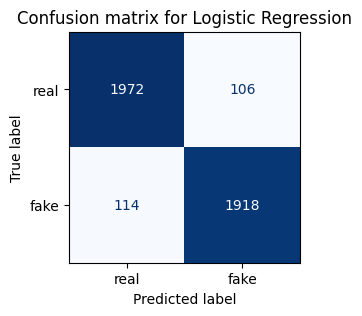



==================== Naive Bayes ====================

Test Accuracy:89.6%

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2078
           1       0.98      0.80      0.88      2032

    accuracy                           0.90      4110
   macro avg       0.91      0.90      0.90      4110
weighted avg       0.91      0.90      0.90      4110



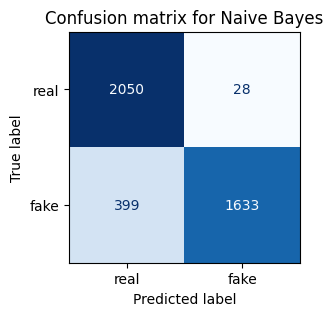



==================== Linear SVM ====================

Test Accuracy:96.3%

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2078
           1       0.96      0.96      0.96      2032

    accuracy                           0.96      4110
   macro avg       0.96      0.96      0.96      4110
weighted avg       0.96      0.96      0.96      4110



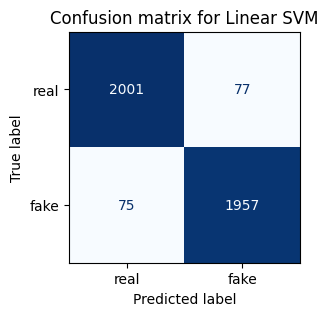

In [17]:
models_trained = {}
for name, model in models.items():
    fitted_model, accuracy = evaluate_model(name, model, X_train_tfidf, y_train, X_test_tfidf, y_test)
    models_trained[name+" Tfidf"] = {'fitted_model': fitted_model, 'test_accuracy':accuracy}

## TF-IDF + Style Features

In [18]:
scaler = MinMaxScaler()
X_train_style_scaled = scaler.fit_transform(X_train_style)
X_test_style_scaled = scaler.transform(X_test_style)

In [19]:
# combining sparse tfidf with dense scaled style features
X_train_combined_scaled = hstack([X_train_tfidf, X_train_style_scaled])
X_test_combined_scaled = hstack([X_test_tfidf, X_test_style_scaled])



==================== Logistic Regression ====================

Test Accuracy:94.7%

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2078
           1       0.95      0.95      0.95      2032

    accuracy                           0.95      4110
   macro avg       0.95      0.95      0.95      4110
weighted avg       0.95      0.95      0.95      4110



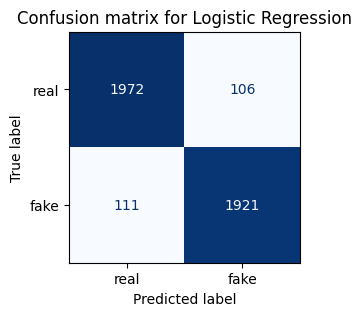



==================== Naive Bayes ====================

Test Accuracy:92.1%

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2078
           1       0.98      0.86      0.92      2032

    accuracy                           0.92      4110
   macro avg       0.93      0.92      0.92      4110
weighted avg       0.93      0.92      0.92      4110



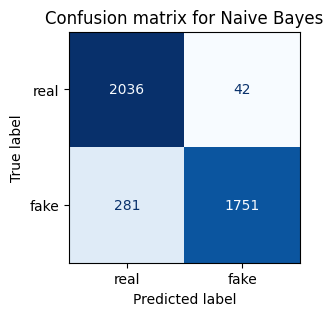



==================== Linear SVM ====================

Test Accuracy:96.5%

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2078
           1       0.96      0.97      0.96      2032

    accuracy                           0.97      4110
   macro avg       0.97      0.97      0.97      4110
weighted avg       0.97      0.97      0.97      4110



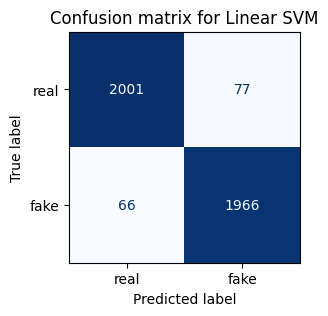

In [20]:
for name, model in models.items():
    fitted_model, accuracy = evaluate_model(name, model, X_train_combined_scaled, y_train, X_test_combined_scaled, y_test)
    models_trained[name+" Combined"] = {'fitted_model': fitted_model, 'test_accuracy':accuracy}

## Save Best Model

In [21]:
max_accuracy = float('-inf')
best_model_name = None
for name, model_info in models_trained.items():
    if model_info['test_accuracy'] > max_accuracy:
        max_accuracy = model_info['test_accuracy']
        best_model_name = name
print(f"Best baseline model: {best_model_name}\nBest test accuracy: {max_accuracy}")

Best baseline model: Linear SVM Combined
Best test accuracy: 0.9652068126520681


* As understood from the distribution plots for the stylometric features, they don't contribute significantly in the classification of news, but they do provide minute information which have helped all the 3 models perform slightly better.
* With both TF-IDF only and combined datasets, Linear SVC performed the best in terms of accuracy and average precision, recall, and f1-score.
* The improvement observed after including the scaled stylometric features were almost negligible for logistic regression and linear svc (0.1% and 0.2% increase, respectively), but slightly appreciable for naive bayes (2.5% increase). Naive bayes was also better at detecting real news than the other 2 models, but not so at identifying the fake ones.

In [22]:
joblib.dump(models_trained[best_model_name]['fitted_model'], 'artifacts/fake_news_baseline_classifier.pkl')

['artifacts/fake_news_baseline_classifier.pkl']